<a href="https://colab.research.google.com/github/artu134/NN_Reinforsed/blob/master/Moon_test_In_LSTMv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/artu134/NN_Reinforsed.git

Cloning into 'NN_Reinforsed'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 39 (delta 10), reused 14 (delta 1), pack-reused 0
Unpacking objects: 100% (39/39), 2.42 MiB | 1.78 MiB/s, done.


In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,CuDNNLSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import re

# Imports for visualisations
from IPython.display import display
import keras.backend as K

In [3]:
from NN_Reinforsed.Generator.tidal_waves_gen import Generator
import datetime

coordinates = (37.7749,-122.4194)#(lat,lon) San Francisco
start_date =  datetime.datetime.strptime('2023-05-10','%Y-%m-%d') # Start date (YYYY-MM-DD)
days = 28*40

# Generate tidal data
generator = Generator(coordinates[0], coordinates[1])
tidal_data_s = generator.get_tidal_data_separate(start_date, days)
tidal_data = generator.get_tidal_data(start_date, days)

In [6]:
tidal_force = list(map(lambda row:[row[1]],tidal_data))
tidal_force_s = list(map(lambda row:[row[1]], tidal_data_s["moon"]))

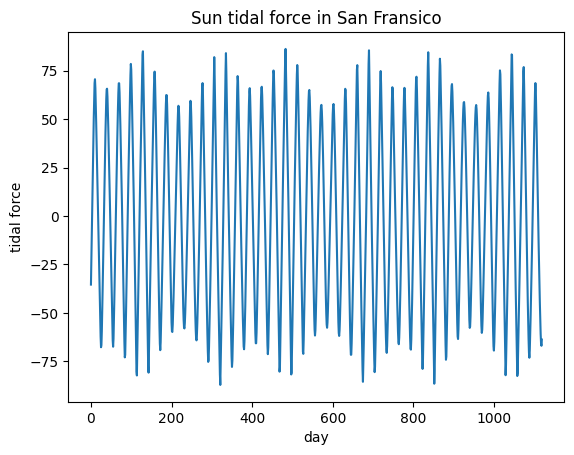

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(tidal_force_s)
plt.title("Sun tidal force in San Fransico")
plt.xlabel("day")
plt.ylabel("tidal force")
plt.show()

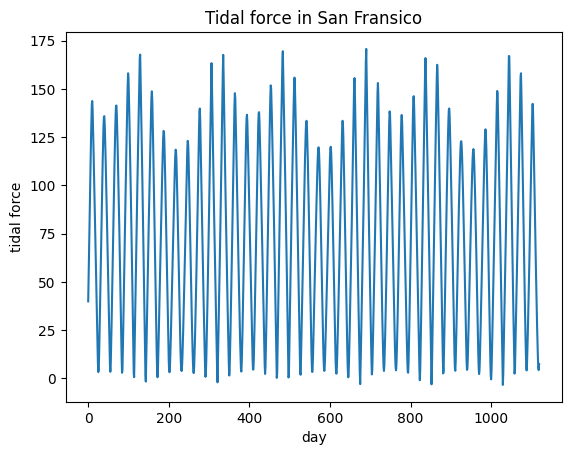

In [8]:
plt.plot(tidal_force)
plt.title("Tidal force in San Fransico")
plt.xlabel("day")
plt.ylabel("tidal force")
plt.show()

Based on the chart we can see two different cycles. Shorter ones are moon phases, and bigger one is Sun phase. Also  there seems to be the third one because there is diffenece in Sun phases

In [9]:
window_size = 28*7
prediction_size = 28

# Data preprocessing

In [10]:
train_end = int(len(tidal_force)*0.6)
val_end = train_end + int(len(tidal_force)*0.2)
train_raw = tidal_force[:train_end]
val_raw = tidal_force[train_end:val_end]
test_raw = tidal_force_s[val_end:]

In [11]:
len(train_raw),len(val_raw),len(test_raw)

(672, 224, 224)

In [12]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

In [13]:
import numpy as np
training_set_raw_scaled = sc.fit_transform(train_raw)

X_train = []
y_train = []
for i in range(window_size, len(training_set_raw_scaled)):
    if i+prediction_size > len(training_set_raw_scaled):
      break
    X_train.append(training_set_raw_scaled[i-window_size:i])
    y_train.append(training_set_raw_scaled[i:i+prediction_size])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [14]:
X_train.shape, y_train.shape

((449, 196, 1), (449, 28, 1))

In [15]:
val_set_raw_scaled = sc.transform(val_raw)

X_val = []
y_val = []
for i in range(window_size, len(val_set_raw_scaled)):
    if i+prediction_size > len(val_set_raw_scaled):
      break
    X_val.append(val_set_raw_scaled[i-window_size:i])
    y_val.append(val_set_raw_scaled[i:i+prediction_size])
X_val, y_val = np.array(X_val), np.array(y_val)

X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [16]:
X_val.shape, y_val.shape

((1, 196, 1), (1, 28, 1))

In [17]:
test_set_raw_scaled = sc.transform(tidal_force_s)
X_test = []
Y_test = []
for i in range(window_size, len(test_set_raw_scaled)-prediction_size):
    X_test.append(test_set_raw_scaled[i-window_size:i])
    Y_test.append(test_set_raw_scaled[i:i+prediction_size])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [18]:
from keras.callbacks import ModelCheckpoint
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Model creation

In [19]:
regressor = Sequential()

regressor.add(LSTM(units = 512,
                   activation='tanh',
                   return_sequences = True,
                   input_shape = (X_train.shape[1], 1)))
#regressor.add(Dropout(0.2))

#mdl.add(LSTM(64, return_sequences=True))
regressor.add(LSTM(64, return_sequences=False))

#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.25))

#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.25))

#regressor.add(LSTM(units = 50))
#regressor.add(Dropout(0.25))

regressor.add(Dense(units = prediction_size,activation='linear'))

regressor.compile(optimizer = 'adam', loss = 'mean_absolute_error')
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 196, 512)          1052672   
                                                                 
 lstm_1 (LSTM)               (None, 64)                147712    
                                                                 
 dense (Dense)               (None, 28)                1820      
                                                                 
Total params: 1,202,204
Trainable params: 1,202,204
Non-trainable params: 0
_________________________________________________________________


# Model Training

In [20]:
history = regressor.fit(X_train, y_train, validation_data=(X_val,y_val), epochs = 5, batch_size = 32, callbacks=callbacks_list)

Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 0.2825
Epoch 1: loss improved from inf to 0.28246, saving model to weights-improvement-01-0.2825.hdf5
15/15 [==============================] - 10s 92ms/step - loss: 0.2825 - val_loss: 0.1679
Epoch 2/5
13/15 [=========================>....] - ETA: 0s - loss: 0.1853
Epoch 2: loss improved from 0.28246 to 0.18083, saving model to weights-improvement-02-0.1808.hdf5
15/15 [==============================] - 0s 33ms/step - loss: 0.1808 - val_loss: 0.1084
Epoch 3/5
13/15 [=========================>....] - ETA: 0s - loss: 0.0925
Epoch 3: loss improved from 0.18083 to 0.09126, saving model to weights-improvement-03-0.0913.hdf5
15/15 [==============================] - 1s 35ms/step - loss: 0.0913 - val_loss: 0.0708
Epoch 4/5
13/15 [=========================>....] - ETA: 0s - loss: 0.0601
Epoch 4: loss improved from 0.09126 to 0.05952, saving model to weights-improvement-04-0.0595.hdf5
15/15 [==============================] - 1s 37m

Text(0.5, 1.0, 'Loss')

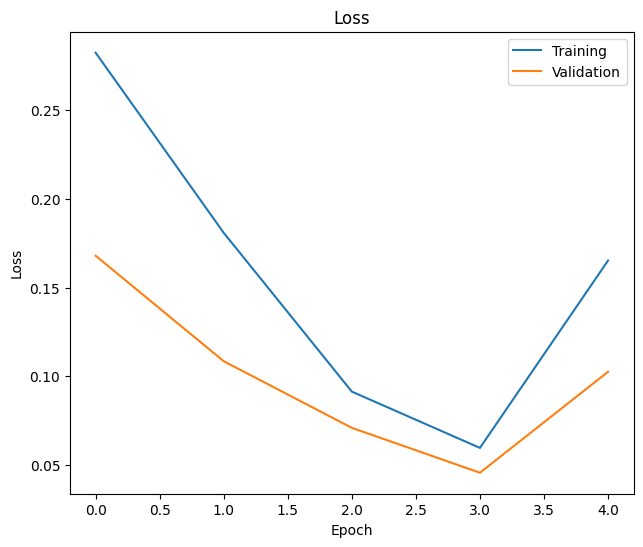

In [21]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

In [22]:
# 1st layer is LSTM layer with output shape (Batch_Size, 512)
lstm1 = regressor.layers[0]

# Get output from intermediate layer to visualize activations
attn_func1 = K.function(inputs = [lstm1.input],
           outputs = [lstm1.output]
          )
# 1st layer is LSTM layer with output shape (Batch_Size, 512)
lstm2 = regressor.layers[1]

# Get output from intermediate layer to visualize activations
attn_func2 = K.function(inputs = [lstm1.input],
           outputs = [lstm2.output]
          )

In [23]:
X_val.shape

(1, 196, 1)

In [24]:
X_val[0].shape

(196, 1)

In [25]:
l1 = attn_func1([X_test[0]])[0]
l1 = l1.reshape(l1.shape[0],l1.shape[-1])
l1.shape

(196, 512)

In [26]:
l2 = attn_func2([X_test[0]])[0]
l2.shape

(196, 64)

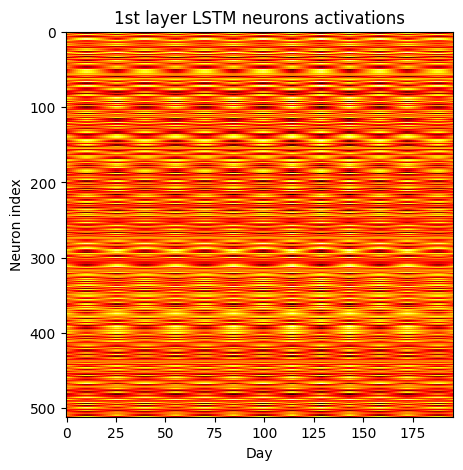

In [27]:
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['figure.dpi'] = 100
plt.imshow(l1.T, cmap='hot', interpolation='nearest', aspect='auto')
plt.title("1st layer LSTM neurons activations")
plt.xlabel("Day")
plt.ylabel("Neuron index")
plt.show()

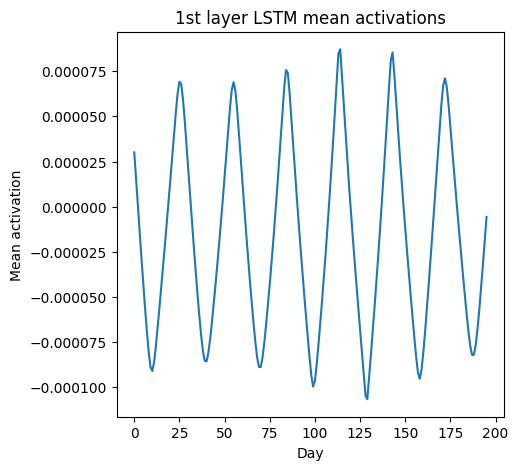

In [28]:
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['figure.dpi'] = 100
plt.plot(l1.mean(axis=1))
plt.title("1st layer LSTM mean activations")
plt.xlabel("Day")
plt.ylabel("Mean activation")
plt.show()

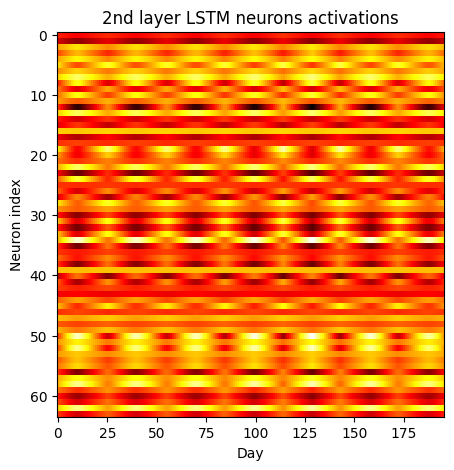

In [29]:
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['figure.dpi'] = 100
plt.imshow(l2.T, cmap='hot', interpolation='nearest', aspect='auto')
plt.title("2nd layer LSTM neurons activations")
plt.xlabel("Day")
plt.ylabel("Neuron index")
plt.show()

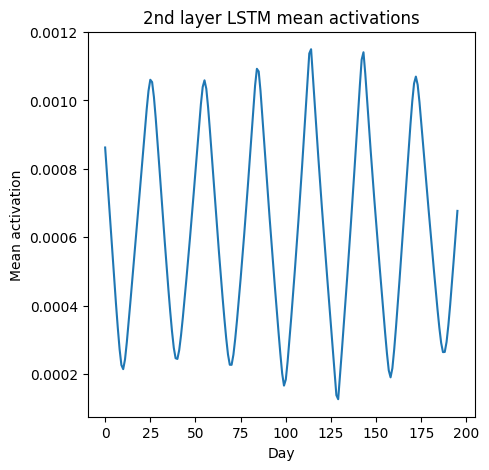

In [30]:
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['figure.dpi'] = 100
plt.plot(l2.mean(axis=1))
plt.title("2nd layer LSTM mean activations")
plt.xlabel("Day")
plt.ylabel("Mean activation")
plt.show()

# Evaluation

In [31]:
train_predicted_norm = regressor.predict(X_train)
train_predicted = sc.inverse_transform(train_predicted_norm)
Y_train = sc.inverse_transform(y_train.reshape(-1,prediction_size))

15/15 [==============================] - 1s 20ms/step


In [32]:
test_predicted_norm = regressor.predict(X_test)
test_predicted = sc.inverse_transform(test_predicted_norm)
Y_test = sc.inverse_transform(np.array(Y_test).reshape(-1,prediction_size))

28/28 [==============================] - 0s 15ms/step


In [33]:
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(Y_train, train_predicted))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(Y_test, test_predicted))
print('Test Score: %.2f RMSE' % (testScore))
#X_train, y_train

Train Score: 28.03 RMSE
Test Score: 40.69 RMSE


In [34]:
np.array(test_raw).shape

(224, 1)

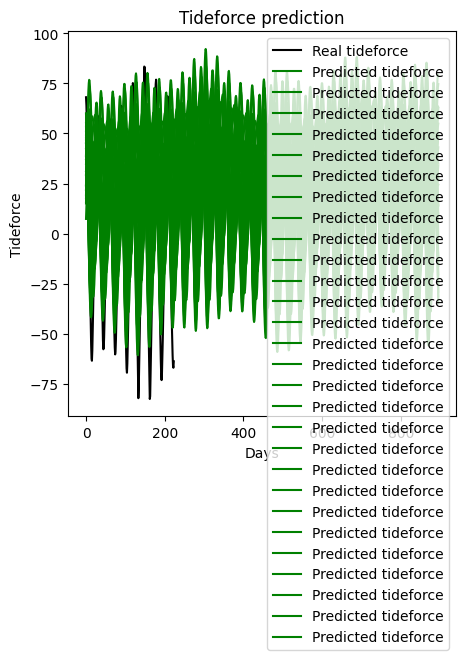

In [35]:
plt.plot(test_raw, color = 'black', label = 'Real tideforce')
plt.plot(test_predicted, color = 'green', label = 'Predicted tideforce')
plt.title('Tideforce prediction')
plt.xlabel('Days')
plt.ylabel('Tideforce')
plt.legend()
plt.show()

In [36]:
input_window = test_set_raw_scaled[:window_size].tolist()
predictions = []
for val in test_set_raw_scaled[window_size:]:
  input = np.array([input_window],dtype=np.float64)
  predicted_norm = regressor.predict(input)
  predicted = sc.inverse_transform(predicted_norm)
  val=predicted.reshape((28))
  predictions.append(val)

  input_window.append(val)
  input_window.pop(0)
  break

1/1 [==============================] - 0s 34ms/step


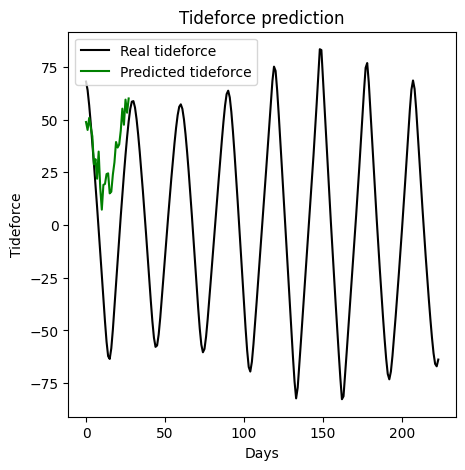

In [37]:
plt.plot(test_raw, color = 'black', label = 'Real tideforce')
plt.plot(predictions[0], color = 'green', label = 'Predicted tideforce')
plt.title('Tideforce prediction')
plt.xlabel('Days')
plt.ylabel('Tideforce')
plt.legend()
plt.show()